# PyTorch tutorial
### Data collection
In this PyTorch tutorial, we use GTZAN dataset which consists of 10 exclusive genre classes. Please run the following script in your local path.

In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
!tar -zxvf genres.tar.gz
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt

### Data loader

In [1]:
import os
import random
import torch
import numpy as np
import soundfile as sf
from torch.utils import data
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train', 
                   num_samples=110250, 
                   num_chunks=8, 
                   batch_size=16, 
                   num_workers=0, 
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, 
                                                       split, 
                                                       num_samples, 
                                                       num_chunks, 
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader


Let's check returned data shapes.

In [2]:
train_loader = get_dataloader(split='train', is_augmentation=True)
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

valid_loader = get_dataloader(split='valid')
test_loader = get_dataloader(split='test')
iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav.shape))
print('validation/test data shape: %s' % str(test_wav.shape))
print(train_genre)

training data shape: torch.Size([16, 110250])
validation/test data shape: torch.Size([2, 8, 110250])
tensor([0, 1, 3, 4, 7, 6, 0, 5, 9, 1, 5, 5, 6, 0, 2, 2])


```{note}
- A data loader returns a tensor of audio and their genre indice at each iteration. 
- Random chunks of audio are cropped from the entire sequence during the training. But in validation / test phase, an entire sequence is split into multiple chunks and the chunks are stacked. The stacked chunks are later input to a trained model and the output predictions are aggregated to make song-level predictions.
```

### Model
We are going to build a simple 2D CNN model with Mel spectrogram inputs. First, we design a convolution module that consists of 3x3 convolution, batch normalization, ReLU non-linearity, and 2x2 max pooling. This module is going to be used for each layer of the 2D CNN.

In [3]:
from torch import nn


class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

Stack the convolution layers. In a PyTorch module, layers are declared in `__init__` and they are built up in `forward` function.

In [4]:
import torchaudio


class CNN(nn.Module):
    def __init__(self, num_channels=16, 
                       sample_rate=22050, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10):
        super(CNN, self).__init__()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels)
        self.layer2 = Conv_2d(num_channels, num_channels)
        self.layer3 = Conv_2d(num_channels, num_channels * 2)
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2)
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 2)
        self.layer6 = Conv_2d(num_channels * 2, num_channels * 2)
        self.layer7 = Conv_2d(num_channels * 2, num_channels * 4)

        # dense layers
        self.dense1 = nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # input batch normalization
        out = out.unsqueeze(1)
        out = self.input_bn(out)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)

        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out


```{note}
In this example, we performed preprocessing on-the-fly using torchaudio. This process can be done offline outside of the network using other libraries such as [librosa](https://librosa.org/doc/latest/index.html) and [essentia](https://essentia.upf.edu/).
```
```{tip}
- There is no activation function at the last layer since `nn.CrossEntropyLoss` already includes softmax in it.
- If you want to perform multi-label binary classification, include `out = nn.Sigmoid()(out)` at the last layer and use `nn.BCELoss()`.
```

### Training
Iterate training. One epoch is defined as visiting all training items once. This definition can be modified in `def __len__` in data loader.

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
valid_losses = []
num_epochs = 30

for epoch in range(num_epochs):
    losses = []

    # Train
    cnn.train()
    for (wav, genre_index) in train_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # Forward
        out = cnn(wav)
        loss = loss_function(out, genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    cnn.eval()
    y_true = []
    y_pred = []
    losses = []
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        loss = loss_function(logits, genre_index)
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), 'best_model.ckpt')

Epoch: [1/30], Train loss: 2.4251
Epoch: [1/30], Valid loss: 2.3378, Valid accuracy: 0.1015
Saving the best model at 0 epochs!
Epoch: [2/30], Train loss: 2.3369
Epoch: [2/30], Valid loss: 2.2404, Valid accuracy: 0.1523
Saving the best model at 1 epochs!
Epoch: [3/30], Train loss: 2.2533
Epoch: [3/30], Valid loss: 2.2164, Valid accuracy: 0.1117
Saving the best model at 2 epochs!
Epoch: [4/30], Train loss: 2.1799
Epoch: [4/30], Valid loss: 1.9759, Valid accuracy: 0.2944
Saving the best model at 3 epochs!
Epoch: [5/30], Train loss: 2.1039
Epoch: [5/30], Valid loss: 2.0422, Valid accuracy: 0.1827
Epoch: [6/30], Train loss: 2.0743
Epoch: [6/30], Valid loss: 2.3303, Valid accuracy: 0.1117
Epoch: [7/30], Train loss: 2.0436
Epoch: [7/30], Valid loss: 1.8615, Valid accuracy: 0.3655
Saving the best model at 6 epochs!
Epoch: [8/30], Train loss: 2.0484
Epoch: [8/30], Valid loss: 2.2032, Valid accuracy: 0.1320
Epoch: [9/30], Train loss: 1.9866
Epoch: [9/30], Valid loss: 1.8399, Valid accuracy: 0.30

### Evaluation
Collect the trained model's predictions for the test set. Chunk-level predictions are aggregated to make song-level predictions.

In [6]:
# Load the best model
S = torch.load('best_model.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

loaded!


Finally, we can assess the performance and visualize a confusion matrix for better understanding.

Accuracy: 0.4690


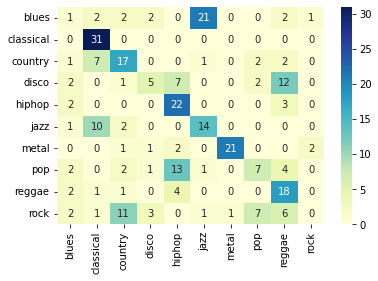

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)

```{tip}
In this tutorial, we did not use any high-level library for more understandable implementation. We highly recommend checking the following libraries for simplified implementation:
- [PyTorch Lightning](https://www.pytorchlightning.ai/)
- [Ignite](https://pytorch.org/ignite/)
- [Hydra](https://hydra.cc/docs/intro/)
```